In [197]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [198]:
# target = "target_close"
target = "close_percent_change_1"

In [199]:
# Load model
# model = pickle.load(open("../model/xgboost_model.pkl", "rb"))


model = xgb.XGBRegressor()
model.load_model("../model/xgboost_model.json")

In [200]:
# print features name
print(len(model.get_booster().feature_names))
model.get_booster().get_score()

477


{'open': 88.0,
 'high': 88.0,
 'low': 106.0,
 'close': 292.0,
 'adj close': 201.0,
 'volume': 68.0,
 'volitility_open_7': 35.0,
 'volitility_pct_change_7_open': 40.0,
 'high_low_7': 22.0,
 'high_close_7': 64.0,
 'low_close_7': 67.0,
 'true_range_7': 20.0,
 'average_true_range_7': 39.0,
 'open_rolling_mean_7': 17.0,
 'open_rolling_exp_mean_7': 9.0,
 'rsi_7': 30.0,
 'short_ema_12': 27.0,
 'long_ema_26': 24.0,
 'macd_12_26': 12.0,
 'signal_9': 16.0,
 'macd_hist_12_26_9': 35.0,
 'stochastic_oscillator_7': 121.0,
 'williams_r_7': 67.0,
 'on_balance_volume_1': 36.0,
 'volume_weighted_average_price_7': 12.0,
 'open_rolling_std_7': 18.0,
 'open_bollinger_upper_7': 21.0,
 'open_bollinger_lower_7': 11.0,
 'open_fib_0.236': 41.0,
 'open_fib_0.382': 57.0,
 'open_fib_0.618': 38.0,
 'open_fib_1.0': 34.0,
 'volitility_open_14': 22.0,
 'volitility_pct_change_14_open': 28.0,
 'high_low_14': 26.0,
 'high_close_14': 15.0,
 'low_close_14': 39.0,
 'true_range_14': 6.0,
 'average_true_range_14': 22.0,
 'ope

In [201]:
# load predictions
df = pd.read_parquet("../data/predicted.parquet")

In [202]:
def normalize_column(data: pd.DataFrame, column: str | list) -> pd.DataFrame:
    if isinstance(column, str):
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    elif isinstance(column, list):
        for col in column:
            data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

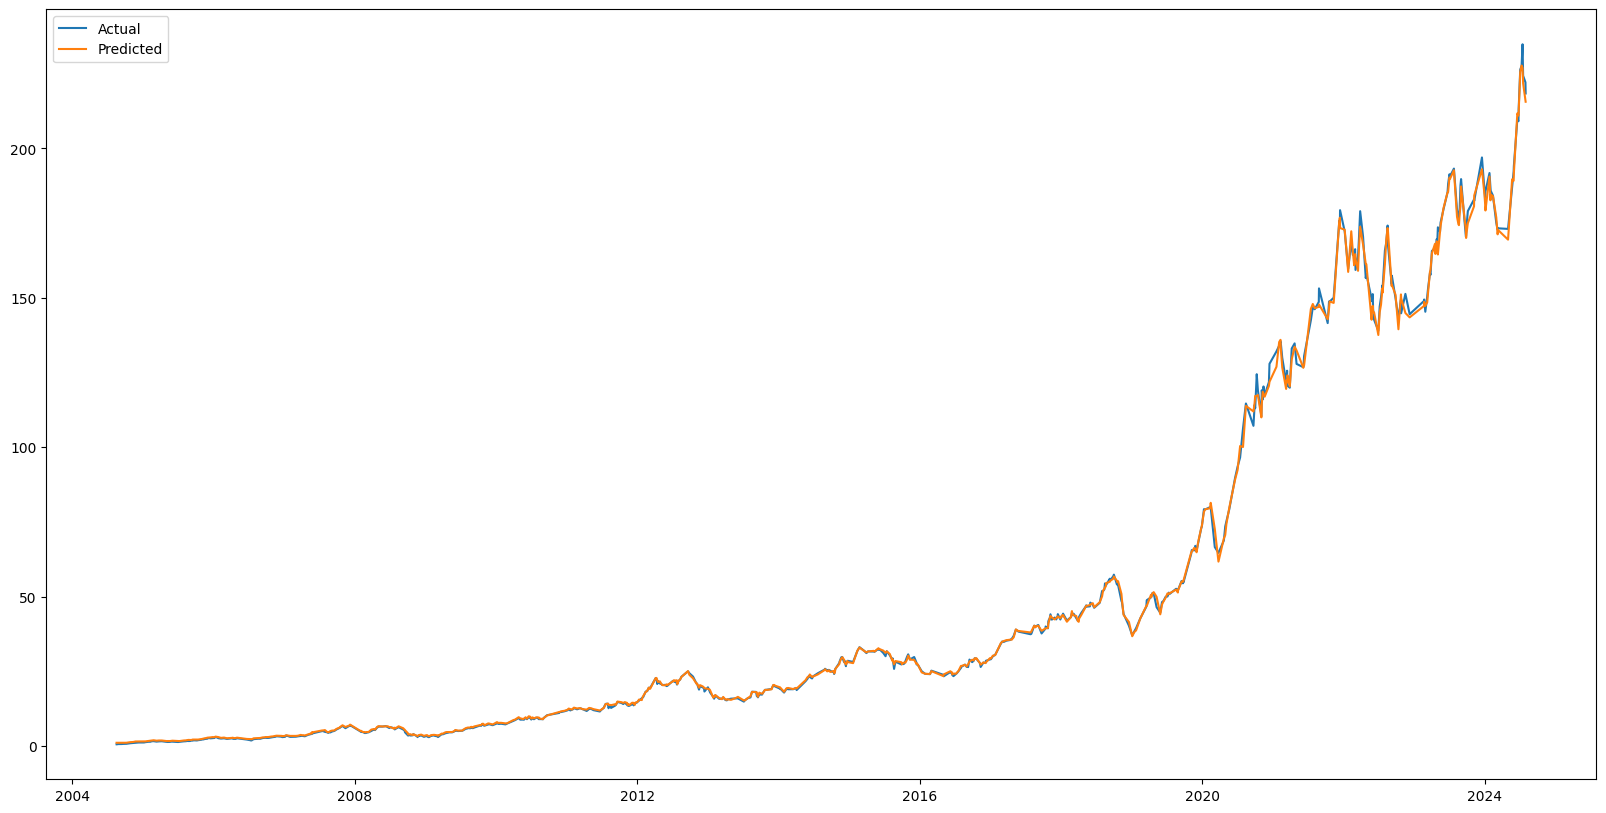

In [203]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(df[target], label="Actual")
plt.plot(df["predicted"], label="Predicted")
plt.legend()
plt.show()

<Axes: xlabel='date', ylabel='value'>

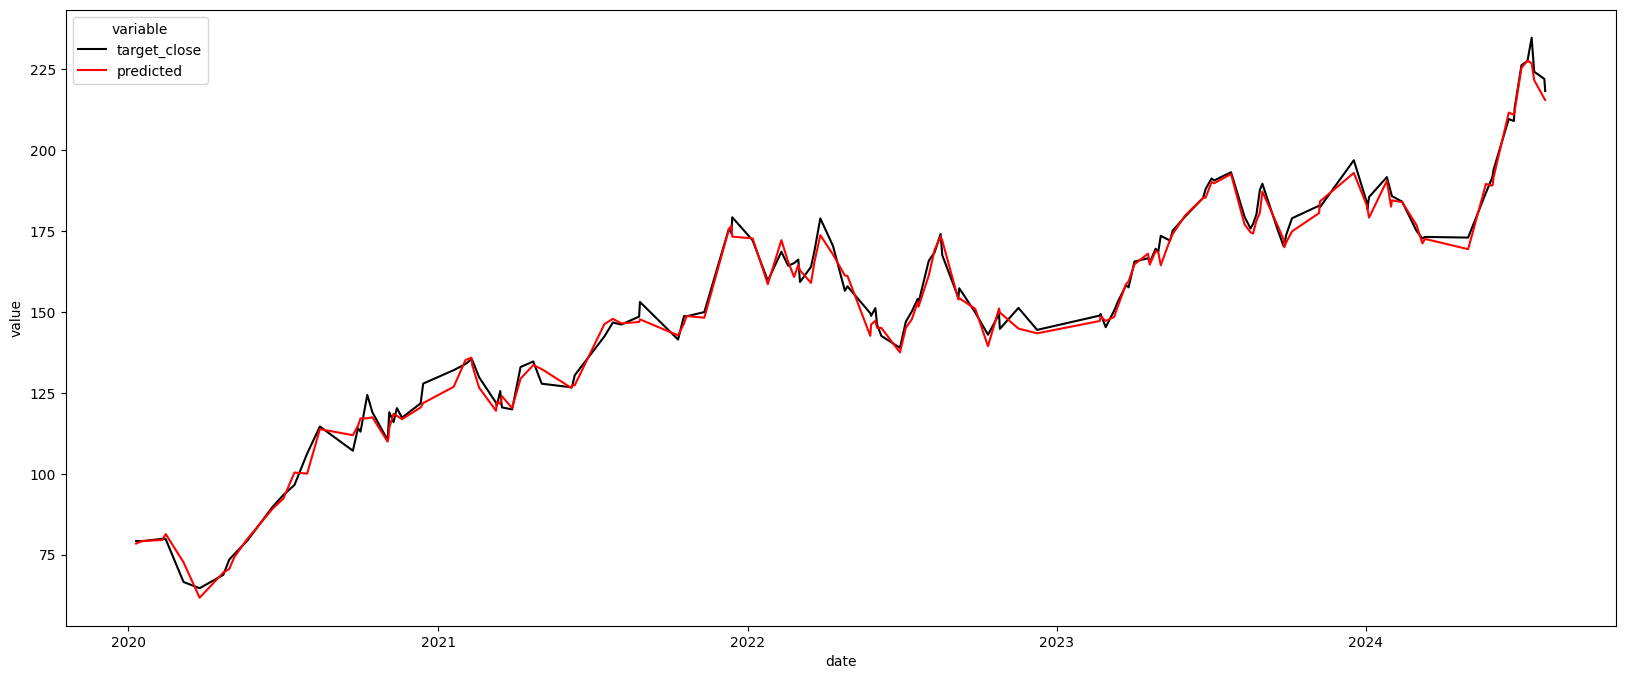

In [210]:
fig, ax = plt.subplots(figsize=(20, 8))
# Only 2008 - 2012 indexs 
df_date = df.loc["2020":"2024"]

sns.lineplot(
    df_date.reset_index().melt(id_vars=["date"], value_vars=[target, "predicted"]),
    y="value",
    x="date",
    hue="variable",
    linewidth=1.5,
    palette=['black', 'red'],
    ax=ax,
)

In [205]:
df_importance = pd.DataFrame()

importance_types = ["weight", "gain", "cover", "total_gain", "total_cover"]
for importance_type in importance_types:
    importance = model.get_booster().get_score(importance_type=importance_type)

    df_i = pd.DataFrame(importance.items(), columns=["feature", importance_type])

    if df_importance.empty:
        df_importance = df_i
    else:
        df_importance = pd.merge(df_importance, df_i, on="feature", how="outer")
df_importance


,feature,weight,gain,cover,total_gain,total_cover
0,adj close,201.0,10518.618164,766.343262,2.114242e+06,154035.0
1,average_true_range_14,22.0,12.781899,118.136360,2.812018e+02,2599.0
2,average_true_range_30,25.0,445.849304,149.960007,1.114623e+04,3749.0
3,average_true_range_7,39.0,7.961454,58.923077,3.104967e+02,2298.0
4,close,292.0,15940.083984,836.890381,4.654504e+06,244372.0
...,...,...,...,...,...,...
455,week_of_year,7.0,11.001807,204.714279,7.701265e+01,1433.0
456,williams_r_14,47.0,8.068528,217.851059,3.792208e+02,10239.0
457,williams_r_30,30.0,8.264508,232.399994,2.479353e+02,6972.0
458,williams_r_7,67.0,4.938659,232.417908,3.308901e+02,15572.0


In [206]:
df_importance = normalize_column(df_importance, ["weight", "gain", "cover", "total_gain", "total_cover"])
df_importance_melted = df_importance.sort_values(by="weight", ascending=True).melt(id_vars=["feature"], value_vars=importance_types)
df_importance_melted

,feature,variable,value
0,low_lag_53,weight,0.000000
1,low_lag_16,weight,0.000000
2,high_lag_9,weight,0.000000
3,close_lag_35,weight,0.000000
4,low_lag_38,weight,0.000000
...,...,...,...
2295,high,total_cover,0.197232
2296,low,total_cover,0.224118
2297,stochastic_oscillator_7,total_cover,0.111711
2298,adj close,total_cover,0.630315


<Axes: xlabel='value', ylabel='feature'>

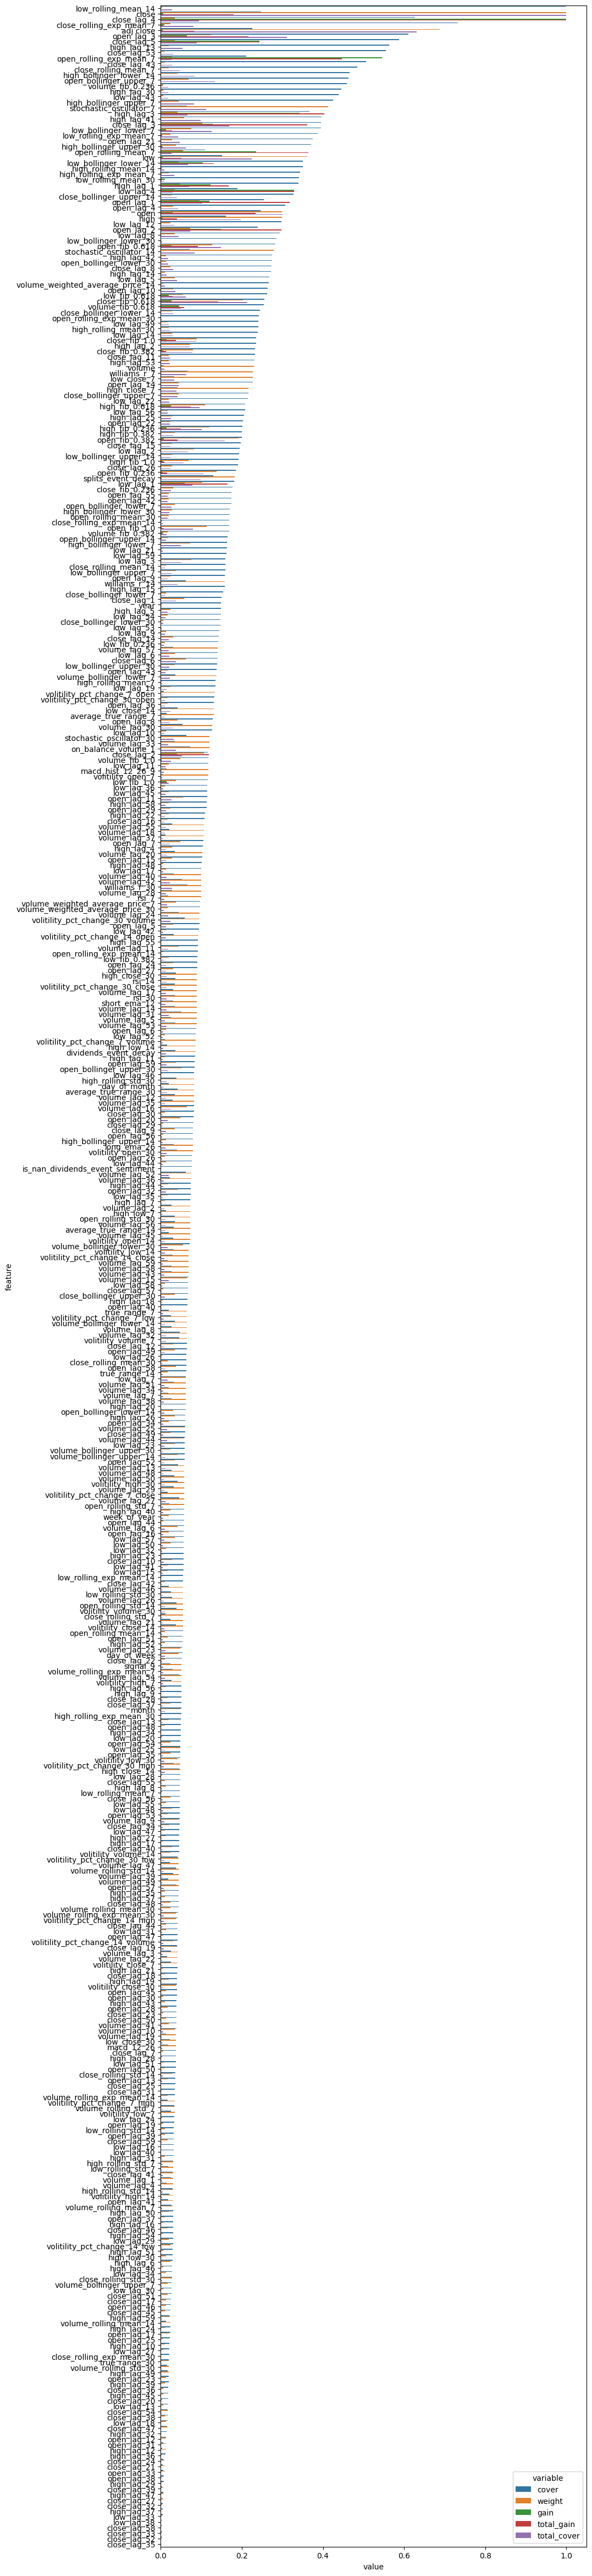

In [207]:
fig, ax = plt.subplots(figsize=(10, 60))
sns.barplot(
    df_importance
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

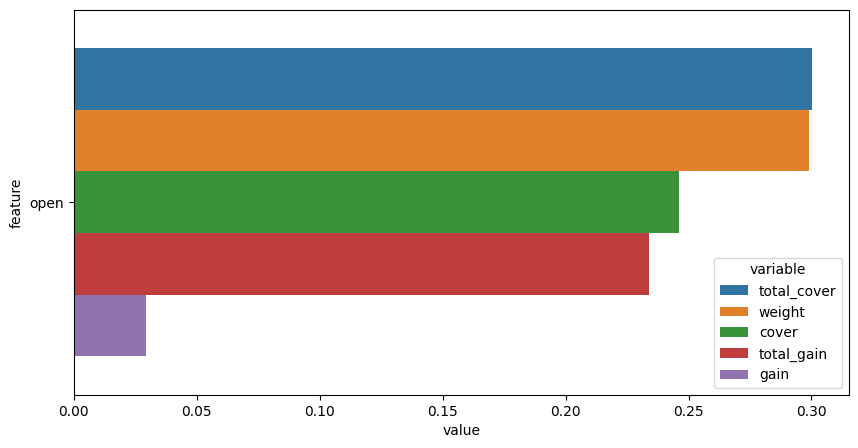

In [208]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    df_importance[df_importance["feature"] == "open"]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

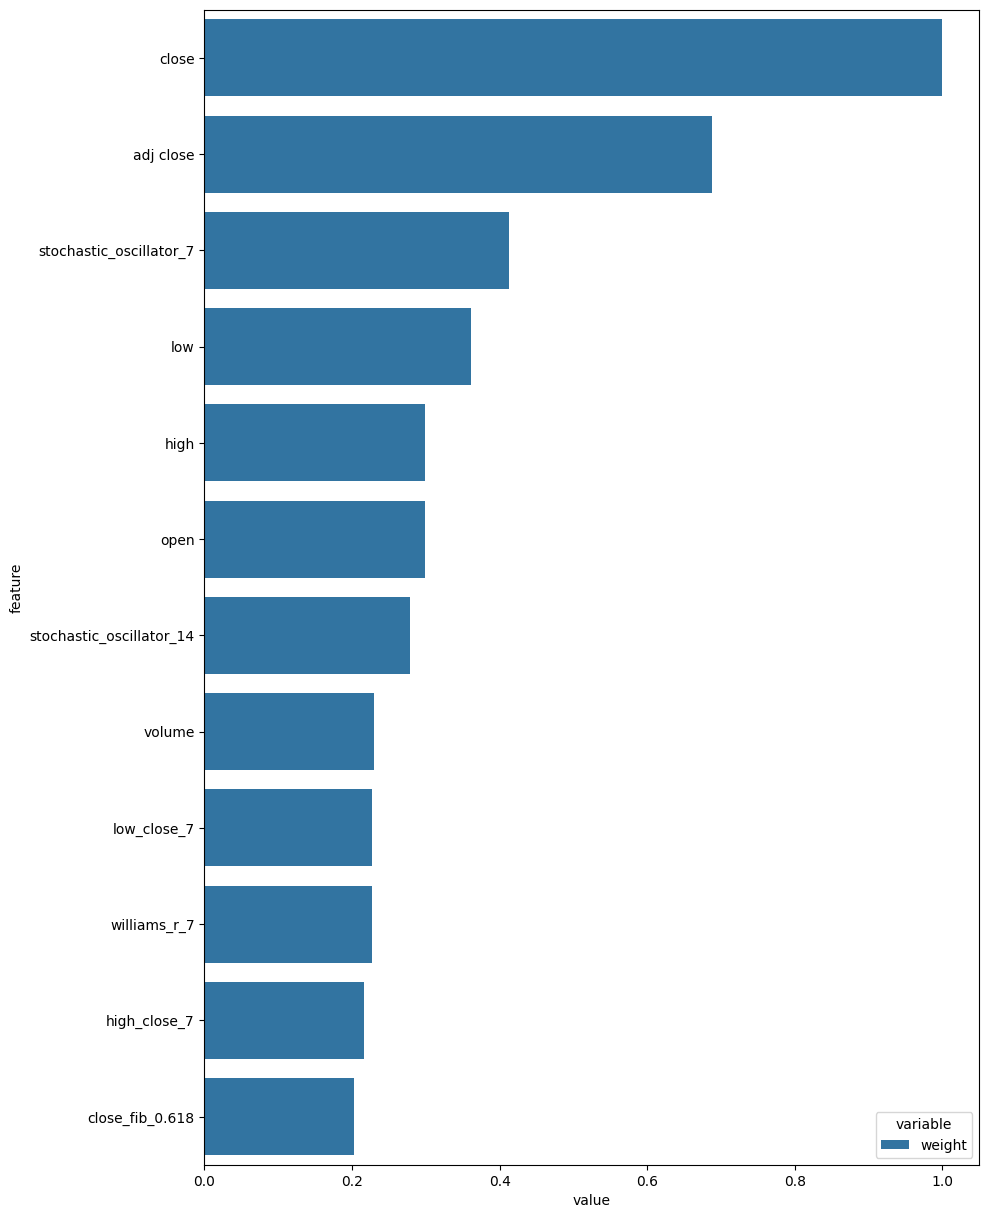

In [209]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(
    df_importance[df_importance["weight"] >= 0.2][["feature", "weight"]]
    .melt(id_vars=["feature"], value_vars=["weight"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)